# 02 — Clustering


In [ ]:
import gdown # need to run '!pip install gdown' to use this
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

# ML and statistics
from scipy.stats import chi2_contingency
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

RANDOM_STATE = 42

## Load prepared data
Run `01_eda.ipynb` first.


In [ ]:
import pandas as pd
from pathlib import Path

prepared_path = Path("data/processed/recalls_prepared.csv")
if not prepared_path.exists():
    raise FileNotFoundError(f"Missing {prepared_path}. Run 01_eda.ipynb first.")
recall_df = pd.read_csv(prepared_path)
print("Loaded:", prepared_path.resolve(), "| rows:", len(recall_df))


##Clustering

In [ ]:
# only uses potentially_affected (log transformed), year, manufacturer here too.
# find besk K with both Elbow method and Silhoutte method > best k = 3
# labeling the severitiy clustering: 0 > low / 1 > medium / 2 > high
# simple visualization but we can add more if we need

In [ ]:

def make_design(df: pd.DataFrame, topN=100):

    required = ["Manufacturer", "Year", "Potentially_Affected_LogTransform", "Potentially Affected"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Work on a local copy
    d = recall_df[required].copy()

    # Limit manufacturer categories
    top = d["Manufacturer"].value_counts().head(topN).index
    d["Manufacturer_reduced"] = np.where(d["Manufacturer"].isin(top), d["Manufacturer"], "Other")

    # One-hot encode manufacturers
    manu = pd.get_dummies(d["Manufacturer_reduced"], prefix="m", drop_first=False).astype("float32")


    # Standardize Year + log-transformed numeric column
    scaler = StandardScaler()
    num = d[["Potentially_Affected_LogTransform", "Year"]].astype("float32")
    num_scaled = pd.DataFrame(
        scaler.fit_transform(num),
        columns=["Potentially_Affected_LogTransform_z", "Year_z"],
        index=d.index,
        dtype="float32"
    )

    # Combine numeric + categorical
    X = pd.concat([num_scaled, manu], axis=1)

    # Keep a copy for labeling later
    df_raw = d[["Manufacturer", "Year", "Potentially Affected"]].copy()
    return X, df_raw


# Prepare features for clustering
X, df_raw = make_design(recall_df)

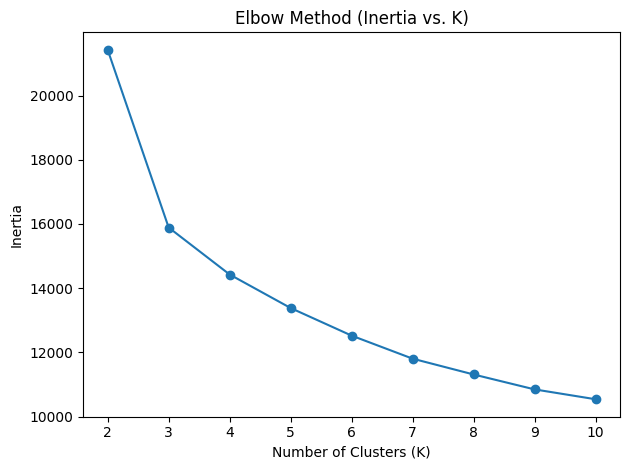

[Elbow] Candidate K = 3
[Silhouette] Candidate K = 3
[Suggested] Best K = 3 (verify using both plots if 3 != 3)


In [ ]:
# Using both Elbow method and Silhouette method to find best k

def find_best_k(X: pd.DataFrame, k_range=range(2, 11), elbow_sample=10000, sil_sample=8000, random_state=RANDOM_STATE):
    #Determine the optimal number of clusters (K) using both the Elbow Method and Silhouette Score.

    # Sampling (for faster computation)
    if len(X) > elbow_sample:
        idx_e = np.random.default_rng(random_state).choice(len(X), size=elbow_sample, replace=False)
        X_elbow = X.iloc[idx_e].values.astype("float32", copy=False)
    else:
        X_elbow = X.values.astype("float32", copy=False)

    if len(X) > sil_sample:
        idx_s = np.random.default_rng(random_state + 1).choice(len(X), size=sil_sample, replace=False)
        X_sil = X.iloc[idx_s].values.astype("float32", copy=False)
    else:
        X_sil = X.values.astype("float32", copy=False)

    # Compute inertia (Elbow) and silhouette scores
    inertia, sil = [], []
    for k in k_range:
        km = KMeans(n_clusters=k, n_init=10, max_iter=300, algorithm="elkan", random_state=random_state)
        labels_elbow = km.fit_predict(X_elbow)
        inertia.append(km.inertia_)

        # Silhouette score on the sampled subset
        labels_sil = km.predict(X_sil)
        sil.append(silhouette_score(X_sil, labels_sil))

    # Elbow plot
    list_k = list(k_range)
    plt.figure()
    plt.plot(list_k, inertia, marker='o')
    plt.title("Elbow Method (Inertia vs. K)")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Inertia")
    plt.tight_layout()
    plt.show()

    # Elbow criterion: choose K with the largest relative drop in inertia
    drops = (np.array(inertia[:-1]) - np.array(inertia[1:])) / np.array(inertia[:-1])
    k_elbow = list_k[np.argmax(drops) + 1]

    # Silhouette criterion: K with the highest silhouette score
    k_sil = list_k[int(np.argmax(sil))]

    # Summarize and recommend
    metrics = pd.DataFrame({
        "k": list_k,
        "inertia": inertia,
        "rel_drop_to_next": np.r_[drops, np.nan],
        "silhouette": sil
    })
    print(f"[Elbow] Candidate K = {k_elbow}")
    print(f"[Silhouette] Candidate K = {k_sil}")

    best_k = k_elbow if k_elbow == k_sil else k_elbow
    print(f"[Suggested] Best K = {best_k} (verify using both plots if {k_elbow} != {k_sil})")

    return best_k, metrics

# Find best K
best_k, k_metrics = find_best_k(X, k_range=range(2, 11))

In [ ]:
def fit_kmeans_and_label(X: pd.DataFrame, df_raw: pd.DataFrame, k: int, random_state = RANDOM_STATE):
    Xv = X.values.astype("float32", copy=False)

    km = KMeans(n_clusters=k, n_init=10, max_iter=300, algorithm="elkan", random_state=random_state)
    labels = km.fit_predict(Xv)

    out = df_raw.copy()
    out["cluster"] = labels

    # Rank clusters by median "Potentially Affected"
    med_order = (
        out.groupby("cluster")["Potentially Affected"]
          .median().sort_values().index.tolist()
    )
    order_map = {c: i+1 for i, c in enumerate(med_order)}
    out["severity_level"] = out["cluster"].map(order_map)
    name_map = {1: "Low", 2: "Medium", 3: "High", 4: "Severe", 5: "Critical"}
    out["severity_label"] = out["severity_level"].map(lambda r: name_map.get(r, f"S{r}"))

    return out, km

# Run K-Means and label each recall by severity
df_labeled, model = fit_kmeans_and_label(X, df_raw, k=best_k)

=== Recall Severity Summary ===
                count       mean   median  min       max
severity_label                                          
Low             11995     246.74    102.0    0      2294
Medium           5883   17995.99    820.0    1   6682084
High             7686  113214.26  13613.5  895  21000000




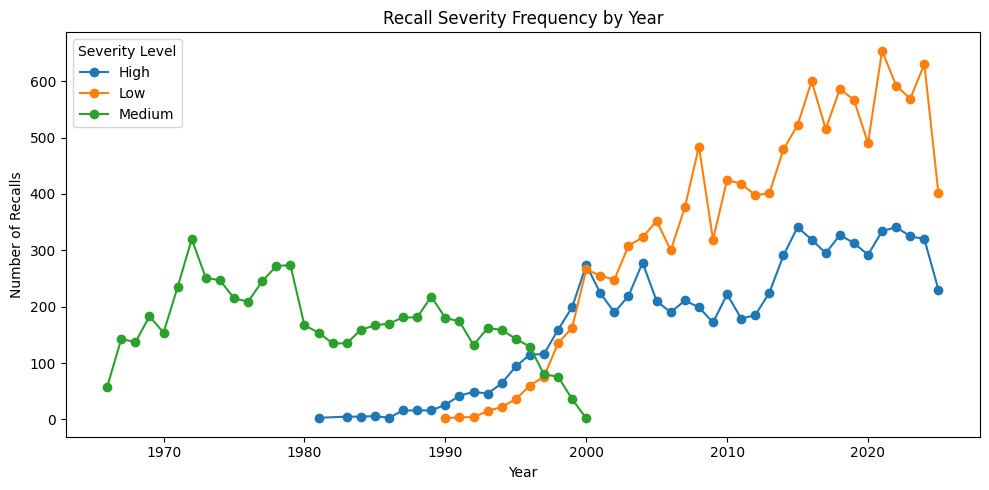

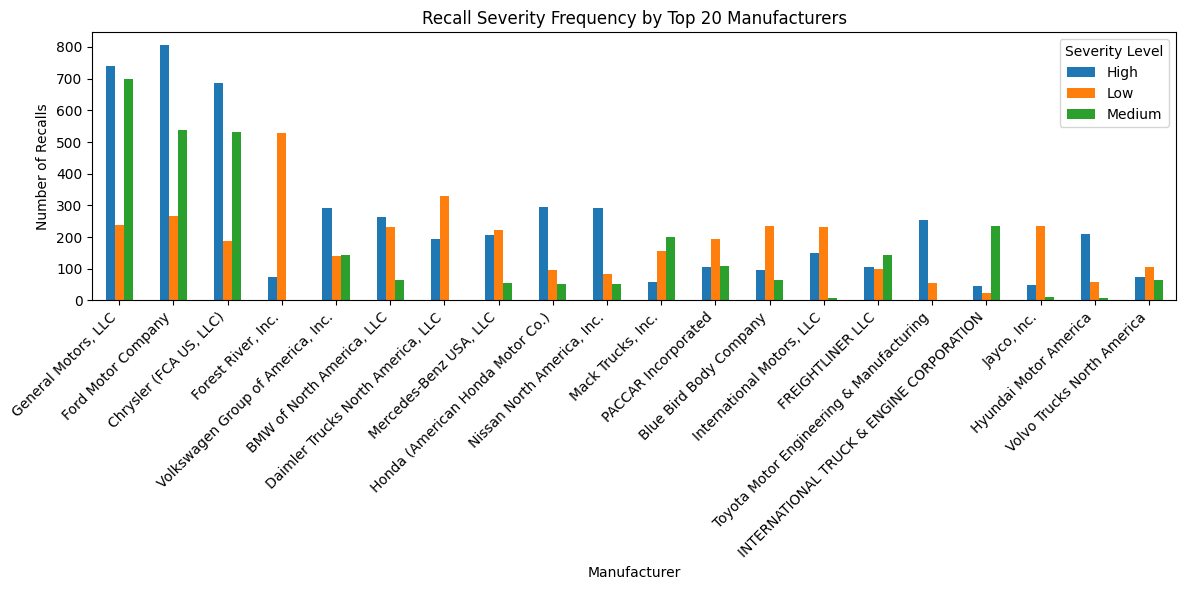

severity_label,High,Low,Medium
Manufacturer,,,
"General Motors, LLC",739,237,699
Ford Motor Company,806,268,537
"Chrysler (FCA US, LLC)",687,189,531
"Forest River, Inc.",74,530,0
"Volkswagen Group of America, Inc.",293,141,143
"BMW of North America, LLC",263,233,63
"Daimler Trucks North America, LLC",194,329,0
"Mercedes-Benz USA, LLC",208,222,56
Honda (American Honda Motor Co.),296,97,51


In [ ]:
def summary_and_plots(df_labeled: pd.DataFrame, top_makers: int = 20):
    print("=== Recall Severity Summary ===")
    print(
        df_labeled.groupby("severity_label")["Potentially Affected"]
        .agg(["count", "mean", "median", "min", "max"])
        .sort_values("median")
        .round(2)
    )
    print("\n")

    # Yearly severity trends (Line = good for time trend)
    plt.figure(figsize=(10, 5))
    for lab, part in df_labeled.groupby("severity_label"):
        cnt = part["Year"].value_counts().sort_index()
        plt.plot(cnt.index, cnt.values, marker="o", label=lab)
    plt.title("Recall Severity Frequency by Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Recalls")
    plt.legend(title="Severity Level")
    plt.tight_layout()
    plt.show()
    print("\n")

    # Top manufacturers (Bar = clearer for comparisons)
    topN = df_labeled["Manufacturer"].value_counts().head(top_makers).index
    sub = df_labeled[df_labeled["Manufacturer"].isin(topN)]

    # manufacturer × severity_label pivot
    pivot = (
        sub.groupby(["Manufacturer", "severity_label"])
        .size()
        .unstack(fill_value=0)
        .reindex(topN)
    )

    # get table by manufacturer
    pivot.plot(kind="bar", stacked=False, figsize=(12, 6))
    plt.title(f"Recall Severity Frequency by Top {top_makers} Manufacturers")
    plt.xlabel("Manufacturer")
    plt.ylabel("Number of Recalls")
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Severity Level")
    plt.tight_layout()
    plt.show()

    # pivot table of manufacturers × severity
    topN = df_labeled["Manufacturer"].value_counts().head(top_makers).index
    sub = df_labeled[df_labeled["Manufacturer"].isin(topN)]
    pivot = (
        sub.groupby(["Manufacturer", "severity_label"])
        .size()
        .unstack(fill_value=0)
        .reindex(topN)
    )

    return pivot

# Visualize and summarize
summary_and_plots(df_labeled, top_makers=20)

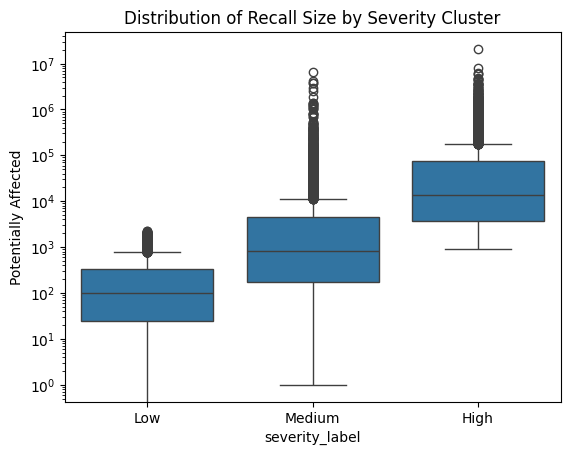

In [ ]:
order = ["Low", "Medium", "High"] # use this order so it is more clear, descriptive

sns.boxplot(
    x="severity_label",
    y="Potentially Affected",
    data=df_labeled,
    order=order
)
plt.title("Distribution of Recall Size by Severity Cluster")
plt.yscale("log")
plt.show()

# Confirms the clustering logic is effective in respect to severity levels correspond directly to recall magnitude
# The High cluster drives most large-scale events, representing systemic or critical failures
# The log normal shape suggests recall size distribution is heavily skewed, dominated by rare large recalls

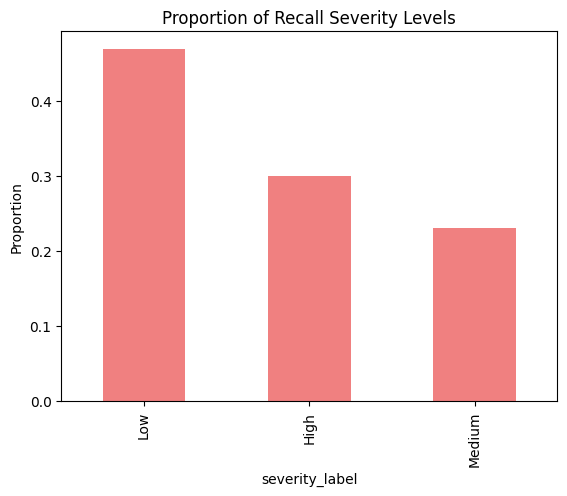

In [ ]:
df_labeled["severity_label"].value_counts(normalize=True).plot(kind="bar", color="lightcoral")
plt.title("Proportion of Recall Severity Levels")
plt.ylabel("Proportion")
plt.show()

Manufacturer Severity Rate Analysis

In [ ]:
# Top 20 manufacturers by number of recalls
top_makers = df_labeled["Manufacturer"].value_counts().head(20).index

# Filter dataset to include only these top manufacturers
df_top = df_labeled[df_labeled["Manufacturer"].isin(top_makers)].copy()

# Manufacturer × Severity label contingency table (counts)
maker_sev_counts = (
    df_top
    .groupby(["Manufacturer", "severity_label"])
    .size()
    .unstack(fill_value=0)
    .loc[top_makers]   # keep the order consistent with value_counts
)

# Convert counts to within-manufacturer severity rates (row-wise normalization)
maker_sev_rates = maker_sev_counts.div(maker_sev_counts.sum(axis=1), axis=0)

print("\n=== Severity Rate (within Manufacturer) ===")
print((maker_sev_rates * 100).round(1).head(20))


=== Severity Rate (within Manufacturer) ===
severity_label                            High   Low  Medium
Manufacturer                                                
General Motors, LLC                       44.1  14.1    41.7
Ford Motor Company                        50.0  16.6    33.3
Chrysler (FCA US, LLC)                    48.8  13.4    37.7
Forest River, Inc.                        12.3  87.7     0.0
Volkswagen Group of America, Inc.         50.8  24.4    24.8
BMW of North America, LLC                 47.0  41.7    11.3
Daimler Trucks North America, LLC         37.1  62.9     0.0
Mercedes-Benz USA, LLC                    42.8  45.7    11.5
Honda (American Honda Motor Co.)          66.7  21.8    11.5
Nissan North America, Inc.                68.6  19.4    11.9
Mack Trucks, Inc.                         13.9  37.7    48.3
PACCAR Incorporated                       25.9  47.6    26.6
Blue Bird Body Company                    23.9  59.4    16.6
International Motors, LLC               

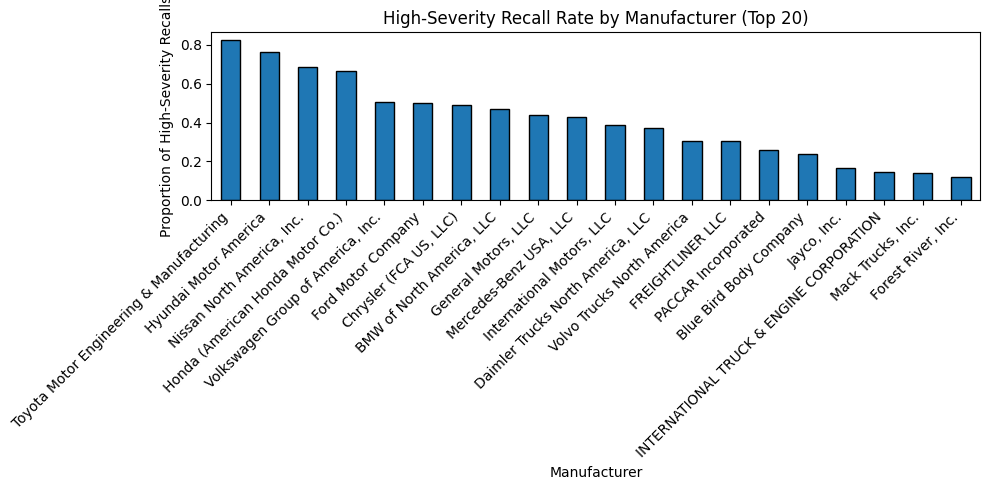

In [ ]:
# Extract High-severity rate (for top 20 manufacturers)
if "High" in maker_sev_rates.columns:
    high_rate = maker_sev_rates["High"].sort_values(ascending=False)
else:
    # If label variations exist such as 'high' or 'HIGH', print available labels
    print("Check severity_label values:", maker_sev_rates.columns)
    high_rate = maker_sev_rates.iloc[:, 0]  # fallback (manually adjust if needed)

plt.figure(figsize=(10, 5))
high_rate.plot(kind="bar", edgecolor="black")
plt.title("High-Severity Recall Rate by Manufacturer (Top 20)")
plt.ylabel("Proportion of High-Severity Recalls")
plt.xlabel("Manufacturer")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [ ]:
# Further analysis within the clustering: Distribution of components within each severity cluster
# Below two are same analysis with different visualization

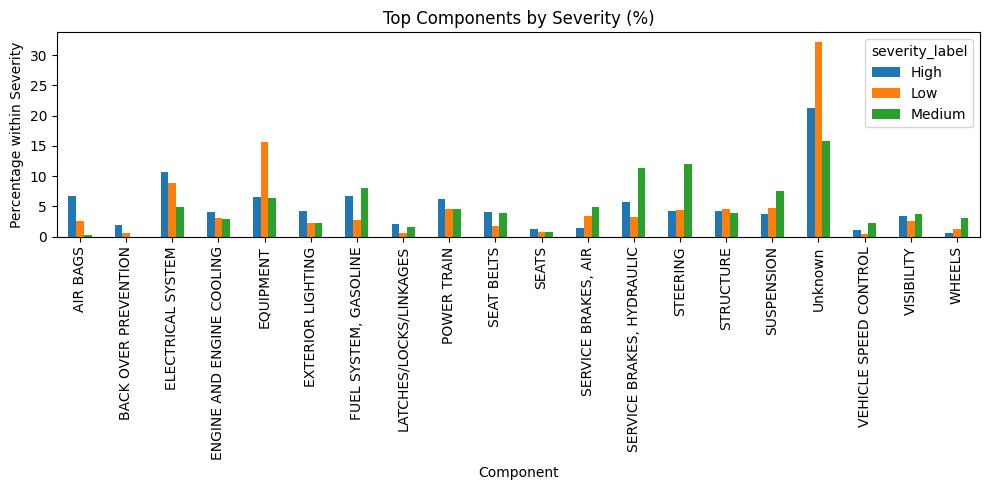

=== Top 5 Components within Each Severity Cluster ===

High severity:
  - Unknown: 21.31%
  - ELECTRICAL SYSTEM: 10.72%
  - FUEL SYSTEM, GASOLINE: 6.65%
  - AIR BAGS: 6.65%
  - EQUIPMENT: 6.61%

Low severity:
  - Unknown: 32.16%
  - EQUIPMENT: 15.71%
  - ELECTRICAL SYSTEM: 8.79%
  - SUSPENSION: 4.70%
  - STRUCTURE: 4.56%

Medium severity:
  - Unknown: 15.77%
  - STEERING: 11.94%
  - SERVICE BRAKES, HYDRAULIC: 11.33%
  - FUEL SYSTEM, GASOLINE: 8.04%
  - SUSPENSION: 7.50%



In [ ]:
top_components = recall_df["Component"].value_counts().head(20).index
sub = recall_df[recall_df["Component"].isin(top_components)]

ct2 = pd.crosstab(df_labeled["severity_label"], sub["Component"], normalize='index') * 100

ct2.T.plot(kind="bar", figsize=(10,5))
plt.title("Top Components by Severity (%)")
plt.ylabel("Percentage within Severity")
plt.tight_layout()
plt.show()

print("=== Top 5 Components within Each Severity Cluster ===\n")
for severity in ct2.index:
    top5 = ct2.loc[severity].sort_values(ascending=False).head(5)
    print(f"{severity} severity:")
    for comp, pct in top5.items():
        print(f"  - {comp}: {pct:.2f}%")
    print()

## Export clustering artifacts
These files are used by `03_evaluation.ipynb`.


In [ ]:
from pathlib import Path
import numpy as np

Path("data/processed").mkdir(parents=True, exist_ok=True)

# Save labeled rows
labeled_path = Path("data/processed/recalls_labeled.csv")
df_labeled.to_csv(labeled_path, index=False)

# Save design matrix (for evaluation)
X_path = Path("data/processed/design_matrix.npy")
np.save(X_path, X.astype("float32"))

# Save chosen K
k_path = Path("data/processed/best_k.txt")
with open(k_path, "w") as f:
    f.write(str(best_k))

print("Saved:")
print("-", labeled_path.resolve())
print("-", X_path.resolve(), "| shape:", X.shape)
print("-", k_path.resolve(), "| best_k:", best_k)
